# Laboratory 2.5: Logistic regression + regularization

Here we will construct our first instance of the **logistic regression classifier** and couple it with some ideas regarding **regularization**. As per usual, you will need the `synthetic_dataset.csv` present in the .zip file you downloaded alongside this notebook. In this case, you also have a `utils.py` file that contains several functions to diagnose your model. Check the inner contents of that file (you will see that there we have some functions you already constructed in previous labs, mostly related to the characterization of the fit). 

In addition, we will be using the following libraries:
- Data management:
    - [numpy](https://numpy.org/)
    - [pandas](https://pandas.pydata.org/)
    - [scipy](https://scipy.org/) 
- Modelling and scoring:
    - [scikit-learn](https://scikit-learn.org)
- Plotting:
    - [seaborn](https://seaborn.pydata.org/)
    - [matplotlib](https://matplotlib.org/)
    
### **All the things you need to do are marked by a "TODO" comment nearby. Make sure you *read carefully everything before working* and solve each point before submitting your solution.**

In [275]:
import numpy as np
import pandas as pd
import os
import sys
# Get the absolute path of the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Add it to sys.path
sys.path.insert(0, project_root)

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# From the "utils.py" file you will only need this...
from src.utils import classification_report

The following cell defines the class for the logistic regression model. In here, we will recover the same structure we have followed thus far in the course, implementing the same models we have used before but now in this new context. 

Here you can reuse the different functions you have implemented in previous notebooks to make your life easier (and, in fact, you will _need_ some of those functions here in order to make this model work).

**Before you start to work here, please read everything carefully, including the comments describing the inner workings of each method implemented. _Do not rush into writing code_, do things in an ordered fashion.**

For the initial part of the lab you will only need to complete the `.fit`, `.log_likelihood` and the `.sigmoid` method, since you will not perform regularization just yet. **Complete the code of this class as you need it**: Fill the `.fit` and the basic related methods as soon as you need it for later cells, leaving the regularization-related methods for later.

In [276]:
from src.Lab2_5_LogisticRegression_and_regularization import LogisticRegressor

Now, let us import the dataset, as usual. Load the `synthetic_data.csv` file and split it into `X` (inputs) and `y` (output). The input variables are named as `input_XX` and the (sole) target variable is named `target`. As you will see, it is a dataset where the target variable is binary categorical, coded with `1`s and `0`s. 

In [277]:
df = pd.read_csv("synthetic_dataset.csv", sep = ",")
print(df.shape) 

print(df.describe() )


(5000, 21)
           input_1      input_2      input_3      input_4      input_5  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean      0.511043    -0.354698     0.037617    -0.326316    -0.031883   
std       1.503533     1.049446     1.401959     0.651552     1.263254   
min      -5.784631    -4.272800    -4.284453    -2.937595    -3.606581   
25%      -0.391272    -1.043206    -1.052543    -0.724091    -1.038792   
50%       0.639872    -0.281637    -0.197386    -0.186464    -0.183883   
75%       1.510862     0.364566     1.122578     0.140441     0.980423   
max       5.376345     2.846694     4.587923     1.723530     3.602918   

           input_6      input_7      input_8      input_9     input_10  ...  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000  ...   
mean     -0.354698     0.228786    -0.354698    -0.326316    -0.528231  ...   
std       1.049446     1.998681     1.049446     0.651552     1.383074  ...   
min   

In [278]:
# TODO: Separate the X and y values

columnas = [f'input_{i}' for i in range(1, 21)]
X = df[columnas]
y = df['target']


# Convert the pandas dataframes into np.arrays so that we can use all the previous codes we defined
# Warning: Watch out for the dimensions!!
X = X.to_numpy()
y = y.to_numpy()

print(X[0]) 
print(y[:10])

[ 3.03182015 -1.17594895  2.26095686 -0.83867095  2.13048562 -1.17594895
 -0.94737216 -1.17594895 -0.83867095  1.12774776 -1.71436647  1.12774776
 -0.83867095  2.26095686 -2.27672289  1.12774776 -2.27672289 -0.99342083
 -2.27672289 -0.99342083]
[1 1 0 0 0 1 0 1 1 0]


Here you can employ previous code you developed in order to split the data into the two sets for training and testing. In this case, as we have done before, _we will purposefully forget about the validation set_ (it will come back next time, we promise...)

For now, we will give you the code to split the data into train/test using the proportion indicated via the `test_size` parameter. **_However, be sure to understand what is being done here, do not dismiss this step._**

In [279]:
def train_test_split(X, y, test_size=0.2, stratify=None, random_state=None):
    """
    Splits arrays or matrices into random train and test subsets. This function demonstrates how to 
    divide a dataset into training and testing sets, optionally stratifying the samples and ensuring 
    reproducibility with a random state.

    Parameters:
    - X (np.ndarray): Input features matrix, where rows represent samples and columns represent features.
    - y (np.ndarray): Target labels array, aligned with the samples in X.
    - test_size (float or int): Determines the size of the test set. If float, it represents a proportion 
                                of the dataset; if int, it specifies the number of samples.
    - stratify (np.ndarray): If provided, the function will ensure the class proportions in train and test 
                             sets mirror those of the provided array, typically the target labels array.
    - random_state (int): Seed for the random number generator to ensure reproducible splits.

    Returns:
    - X_train, X_test, y_train, y_test: Arrays containing the split of features and labels into training and 
                                        test sets.
    """
    
    # Set the seed for reproducibility
    if random_state:
        np.random.seed(random_state)

    # Determine the number of samples to allocate to the test set
    n_samples = X.shape[0]
    if isinstance(test_size, float):
        n_test = int(n_samples * test_size)
    else:
        n_test = test_size
    n_train = n_samples - n_test

    # Create an array of indices and shuffle if not stratifying
    indices = np.arange(n_samples)
    if stratify is None:
        np.random.shuffle(indices)
    else:
        # For stratified splitting, determine the distribution of classes
        unique_classes, y_indices = np.unique(stratify, return_inverse=True)
        class_counts = np.bincount(y_indices)
        test_counts = np.round(class_counts * test_size).astype(int)

        # Allocate indices to train and test sets preserving class distribution
        train_indices, test_indices = [], []
        for class_index in range(len(unique_classes)):
            class_indices = indices[y_indices == class_index]
            np.random.shuffle(class_indices)
            boundary = test_counts[class_index]
            test_indices.extend(class_indices[:boundary])
            train_indices.extend(class_indices[boundary:])

        # Concatenate indices to form the final split
        indices = train_indices + test_indices

    # Use the indices to partition the dataset
    X_train = X[indices[:n_train]]
    X_test = X[indices[n_train:]]
    y_train = y[indices[:n_train]]
    y_test = y[indices[n_train:]]

    return X_train, X_test, y_train, y_test


Now that you have the train/test split function, perform the split in your data in the following cell:

In [280]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [281]:
print (len(X_train), len(X_test))
print (len(y_train), len(y_test))

4000 1000
4000 1000


## Training the logistic regression model

Now, it comes the turn to train the logistic regression. Remember, **this model does not have a closed-form solution for the values of the parameters, so instead you have to optimize the parameters recursively via an approximate technique**. There are many different approaches here, but we will resort to the most familiar one: _**gradient descent**_.

In [282]:
# Configuration of logistic regression model
num_iterations = 1000      # Number of iterations to run the gradient_descent algorithm
learning_rate = 0.01       # Learning rate parameter for gradient descent

# You can try different values for these parameters here!
# Watch out: Some values create unexpected responses of the model, so be careful...

Once you have the code, _let's get ready!_ 

Create an instance of your `LogisticRegressor` and run the fit. This should call the `fit` method, which should contain almost the same thing you had in the previous practice for the `fit_gradient_descent` method. You will need to tune it a bit so that it updates the parameters accordingly, but once you have it, you can run the following cell.

In [283]:
LogReg = LogisticRegressor()

# queremos que el modelo nos de una prob de que y = 1 

LogReg.fit(X_train, y_train, learning_rate=learning_rate, num_iterations=num_iterations, verbose=True)

Iteration 0: Loss 0.6931471805599454
Iteration 100: Loss 0.36198273068074266
Iteration 200: Loss 0.3281699516241883
Iteration 300: Loss 0.3176380673802242
Iteration 400: Loss 0.3132191702005506
Iteration 500: Loss 0.3110856194047283
Iteration 600: Loss 0.309968760497831
Iteration 700: Loss 0.30935299690280654
Iteration 800: Loss 0.3090011590957817
Iteration 900: Loss 0.30879482551118337


In [284]:
""" Vemos que va mejorando el modelo al ir reduciendo en cada iteración la función de pérdida """

' Vemos que va mejorando el modelo al ir reduciendo en cada iteración la función de pérdida '

Once the model is fitted, you can try to extract the prediction probabilities for each data point. To this end, extract the predicted probabilities for associated for the predicted values of `y_train` and `y_test` 

In [285]:
# Predict probabilities of train and test datasets
y_train_prob = LogReg.predict_proba(X_train)
y_test_prob = LogReg.predict_proba(X_test)

You will use these values in just a second...

## Fit assessment

In order to see how well our model fits the data, we must resort to the techniques we have constructed in previous laboratories. In particular, we will use the function `classification_report` present in `utils.py`. We strongly encourage you to check out the functions present in that file, as you will see that they represent (our version of) certain functions that may look familiar. 

In particular, take a look at the `classification_report` function. Before you continue, **what does this function do, how do you use it and why could it be interesting for your task here?**
> Esta función nos es útil porque nos proporciona tres gráficos : la curva ROC (midiendo si clasifica bien los datos positivos y negativos), la curva de calibración (para ver la respuesta media de positivos en comparación con las predicciones en cada bin ), y  un histograma para cada clase (para poder ver cómo clasifica las clases). Nos es muy útil para ver , una vez hemos obtenido los mejores parámetros del modelo, cuanta precisión comete. podemos ver si, renunciando a la complejidad y por tanto precisión, cuanto error se comete al "aligerar" el modelo. 

Once you have answered the previous question, let us appy `classification_report` to the fit we obtained. Execute it in the next cell and check out the results.

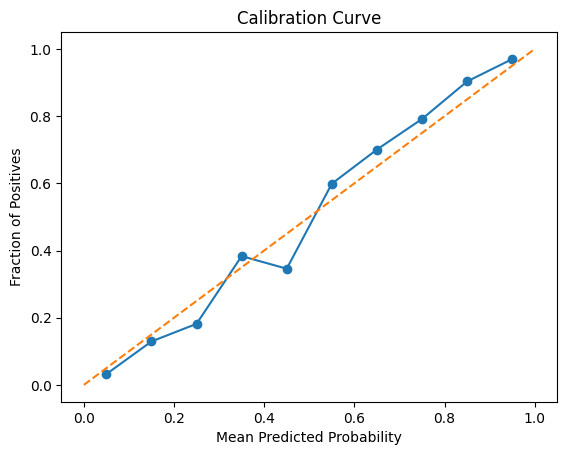

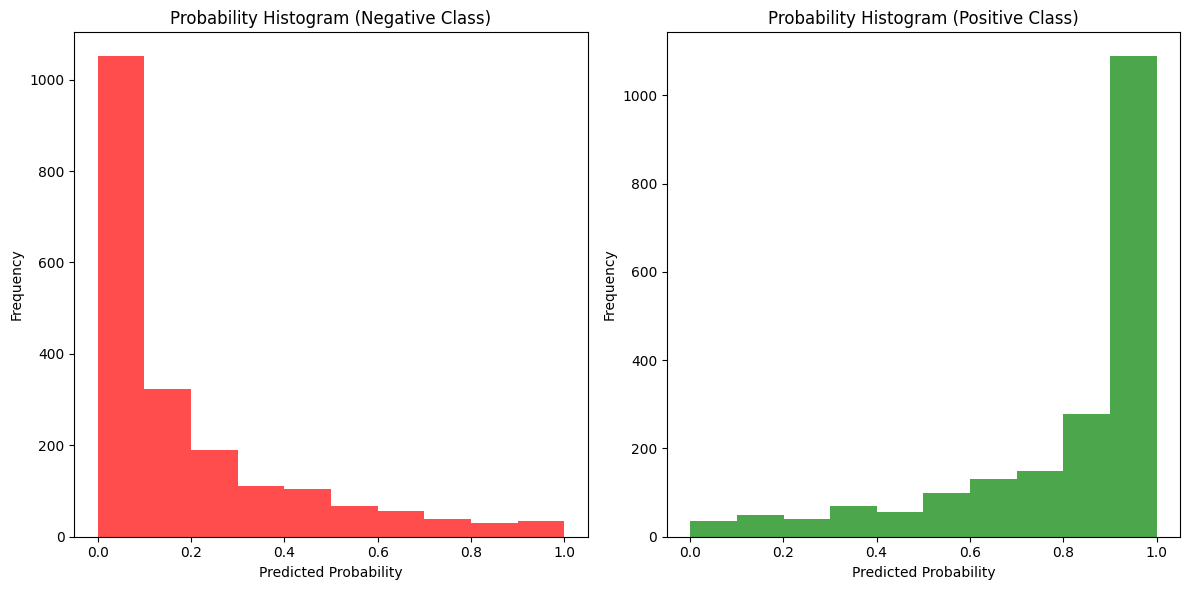

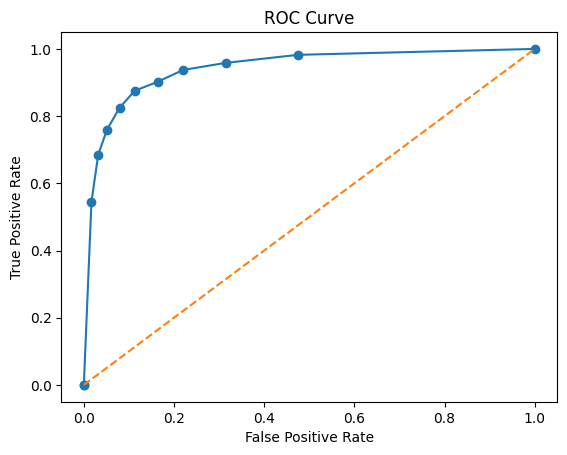

{'Confusion Matrix': [1778, 226, 249, 1747],
 'Accuracy': 0.88125,
 'Precision': 0.88545362392296,
 'Recall': 0.875250501002004,
 'Specificity': 0.8872255489021956,
 'F1 Score': 0.8803224993701184}

In [286]:
# TODO: Apply the classification_report function for the **TRAIN dataset predictions**
# classification_report(y_true, y_probs, positive_label, threshold=0.5, n_bins=10):
classification_report(y_train, y_train_prob, 1)

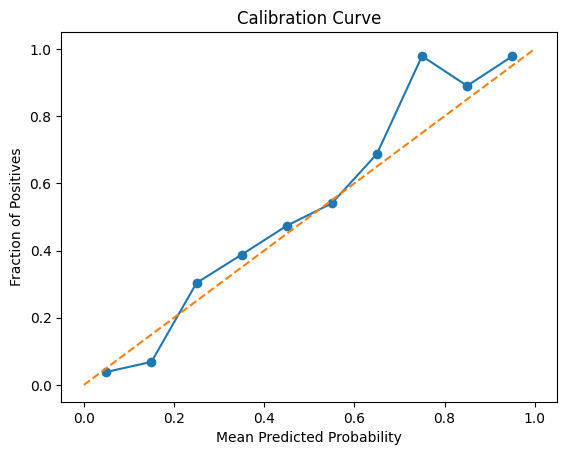

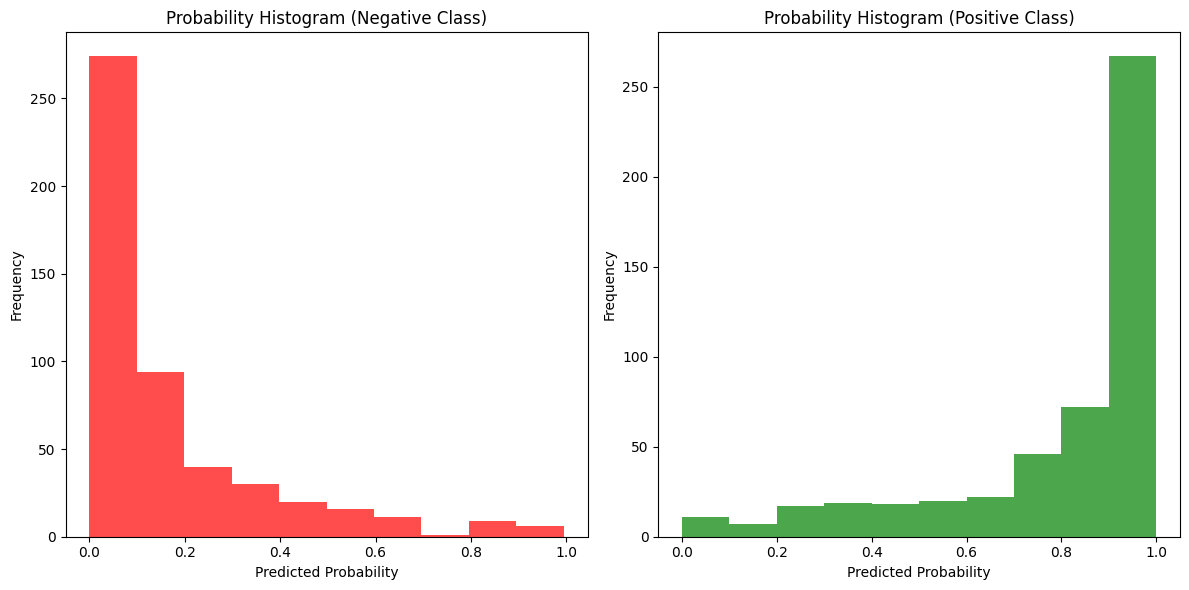

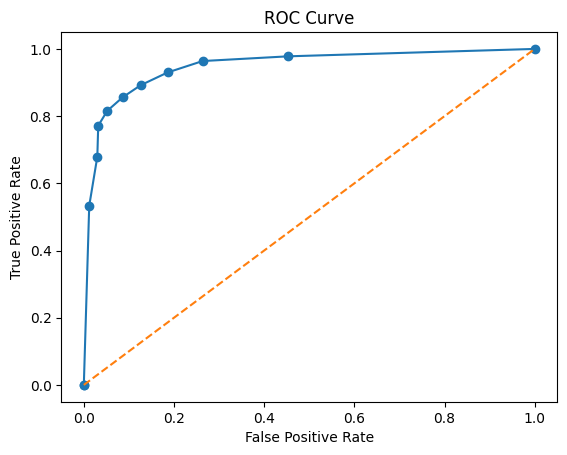

{'Confusion Matrix': [458, 43, 72, 427],
 'Accuracy': 0.885,
 'Precision': 0.9085106382978724,
 'Recall': 0.8557114228456913,
 'Specificity': 0.9141716566866267,
 'F1 Score': 0.8813209494324046}

In [287]:
# TODO: Apply the classification_report function for the **TEST dataset predictions**
classification_report(y_test, y_test_prob, 1)

**What do you think about this results? Do you observe any important features that you think are worth mentioning?**

> Vemos en estos gráficos varias observaciones : 
- En la curva de caligrafía, vemos que el modelo está aproximadamente cerca de la predicción media del modelo, lo cual es bastante bueno e indica mediciones coherentes . 
- Por otro lado, en los histogramas vemos que, en general, el modelo suele estimar con la mayor probabilidad la clase buena, pero hay bastante cola en ambos, lo que 
    significa que está cometiendo errores significativos 
     
- Curva ROC: a pesar de no ser un modelo óptimo, vemos que se acerca mucho más a ello que a la curva del modelo aleatorio, lo que nos indica que se comete algo de error
pero a la vez es un estimador relativamente decente. 

- Matriz de confusión: Vemos, en el primer último valor la cantidad de valores que el modelo acierta, y en los del medio aquellos que falla. 
    Los valores nos indican que, en general, el modelo estima igual de bien la clase 0 que la clase 1, enseñando que están balanceadas. 
- Otras medidas: En general, las medidas nos enseñan lo que ya hemos comentado : es un modelo genralmente bueno pero qeu comete ciertos fallos

Viendo los gráficos del test, vemos que se parecen bastante a los del training, lo cual es muy bueno porque significa que , con aquellos datos uqe no ha visto nunca, es capaz de 
estimar sus valores con prácticmanente la misma precisión. Una de las observaciones que más nos puede llamar la atención es que cuando la prob es aproximadamente 0.8, el modelo 
de repente estima peor que antes, encontrando un pico en la curva de calibración (indicando error) que tambien se ve en los histogramas. Esto se puede deber a una falta de datos. 





## Weights and regularization of the model

Now we have obtained our first fully-functional model of logistic regression (_congrats!_). 

However, in our dataset we have 21 numerical regressors and 0  categorical regressors. Thus, we have a total of 21 input variables (columns) for the model, which entails a total of 22 parameters for the logistic regression model. 

> Fill the gaps in the text above

Since we have **not** conducted preprocessing procedure for the dataset, we may be "doing more than we need". In this case, we have purposefully left out the preprocessing steps so you can see the effects of the next part of this lab: **regularization**.

As you may recall, regularization implies modifying the objective (loss) function a bit in order to reduce the overall complexity of the model. In most cases, complexity is translated into high weight (parameter) values, and thus penalizing large values here will help the model to keep a more reasonable balance in the *bias/variance* trade-off. 

In class we introduced three main regularization techniques: **ridge**, **lasso** and **elastic net** regularization. Each one of those has their special properties, which we will investigate in just a second. Keep in mind, in each case, that modifying the objective function induces a change in the gradients of the gradient descent algorithm, which is why each regularization technique is able to affect the final values for the parameters of the fit.

_If you need to review the ideas behind regularization, now is the time. Make sure you get the gist of it before you continue._

**To perform the things you will need in the next part, you will need to implement the methods `ridge_regularization`, `lasso_regularization` and `elastic_net_regularization` in `LogisticRegressor`**.

### Ridge regularization

**Ridge regularization is performed introducing what in the objective function?**

> La regularizacion de Ridge consiste en reducir el peso de los parámetros de w y de b usando el cuadrado de los pesos. 

Once you have this, let us implement it already!

In [288]:
# We will perform regularization for different values of the regularization parameter
# TODO: Create an array (C_values) that contains 11 values distributed in log-scale, covering from 10^(-5) to 10^5
pow_min = -5
pow_max = 5
C_values = np.logspace(pow_min, pow_max, num=11) # Vector of \lambda (regularization parameters)

# Keep these two empty lists to contain the final weights for each regularization parameter
weights_evolution = []    # To store the final weights for each C
accuracies = []           # To store accuracy for each C


Now, fit a logistic regression with ridge regularization for each possible value of the regularization parameter present in `C_values`.

In [289]:
for C in C_values:
    model = LogisticRegressor()  # Update to include necessary parameters
    model.fit(X_train, y_train, learning_rate = learning_rate, num_iterations = num_iterations, penalty = 'ridge', C = C)
    weights_evolution.append(model.weights)
    
    # Predict and calculate accuracy in the test data
    y_pred = model.predict(X_train)
    accuracy = accuracy_score(y_train, y_pred)
    accuracies.append(accuracy)
    

In [290]:
print(C_values)
print(accuracies)
print (max(accuracies), accuracies.index(max(accuracies)) )

[1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04
 1.e+05]
[0.88125, 0.88125, 0.88125, 0.88125, 0.88125, 0.88125, 0.881, 0.88075, 0.8775, 0.87275, 0.8625]
0.88125 0


In [291]:
"""Vemos que la accuracy es bastante constante en global, aunque cuando C comienza a ser mayor de 1, vemos que reduce ligeramente la accuracy con respecto a la iteración anterior."""

'Vemos que la accuracy es bastante constante en global, aunque cuando C comienza a ser mayor de 1, vemos que reduce ligeramente la accuracy con respecto a la iteración anterior.'

Now, in order to see how well the model behaves, we will plot different things we have access to. This means that we want to plot:
* The evolution for each weight vs. the regularization parameter
* The accuracy of the method vs. the regularization parameter.
    - In this case, mark also the value of the regularization that achieves the highest accuracy
    
**What is the regularization value that achieves highest accuracy?**
> EL mejor valor de C que lo consigue es aquel más pequeño de todos los que alcanzan la maxima accucary, por tanto es 1.e-5

The optimum value of C based on accuracy is: 1e-05


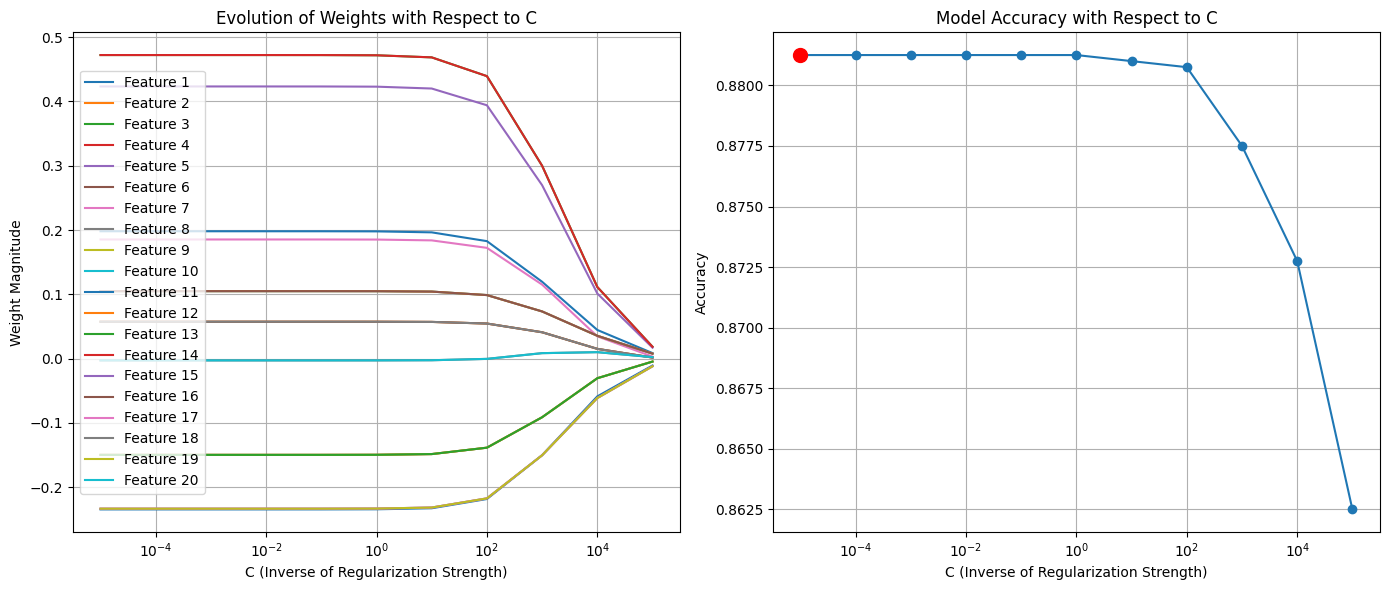

In [292]:
# Plotting the evolution of weights
plt.figure(figsize=(14, 6))

# Plot for the changes in the weights in terms of the regularization parameter
plt.subplot(1, 2, 1)
for feature_index in range(len(weights_evolution[0])):
    weight_trajectory = [weights[feature_index] for weights in weights_evolution]
    plt.plot(C_values, weight_trajectory, label=f'Feature {feature_index + 1}')
plt.xscale('log')
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('Weight Magnitude')
plt.title('Evolution of Weights with Respect to C')
plt.legend(loc='best')
plt.grid(True)

# TODO: Find the maximum accuracy
max_accuracy = max(accuracies)

# TODO: Filter the C values that correspond to the maximum accuracy
optimum_C_values = C_values[:5]

# Select the maximum C from those that yield the highest accuracy
optimum_C = min(optimum_C_values)

print(f"The optimum value of C based on accuracy is: {optimum_C}")

# Plotting accuracy as a function of C
plt.subplot(1, 2, 2)
plt.plot(C_values, accuracies, marker='o', linestyle='-')
plt.plot(optimum_C, max_accuracy, 'ro', markersize=10, label='Optimum C')
plt.xscale('log')
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('Accuracy')
plt.title('Model Accuracy with Respect to C')
plt.grid(True)

plt.tight_layout()
plt.show()

In [293]:
""" Vemos que, para los valores de C que son menores que 1 , los valores siguen siendo los mismos , sin modificar la accuracy del modelo. 
Sin embargo, una vez C es mayor que 1 , a medida que aumenta , los valores de los pesos del modelo van decreciendo hasta llegar a ser 0. 
Correspondientemente, vemos que a la vez la precisión va siendo peor al tener un modelo cada maz mas simple hasta alcanzar 0.8625.  """

' Vemos que, para los valores de C que son menores que 1 , los valores siguen siendo los mismos , sin modificar la accuracy del modelo. \nSin embargo, una vez C es mayor que 1 , a medida que aumenta , los valores de los pesos del modelo van decreciendo hasta llegar a ser 0. \nCorrespondientemente, vemos que a la vez la precisión va siendo peor al tener un modelo cada maz mas simple hasta alcanzar 0.8625.  '

Now, using the model fit with the regularization parameter that induces the highest accuracy, we will create a separate object and train it in the training data with this optimum value of the regularization parameter. We will do this to ease further treatment to measure the performance of this preferred method with the `classification_report` function. 

In [294]:
# Initialize the LogisticRegressor model with the optimum C
LogReg_optimum_C_Ridge = LogisticRegressor()

# TODO: Train the model using the training data and the optimum C
LogReg_optimum_C_Ridge.fit(X_train, y_train, 
                           learning_rate = learning_rate, 
                           num_iterations = num_iterations, 
                           penalty = 'ridge', 
                           C = optimum_C)

Obtain the predictive probabilities for the `y_test`and apply the `classification_report` to check out the results. 

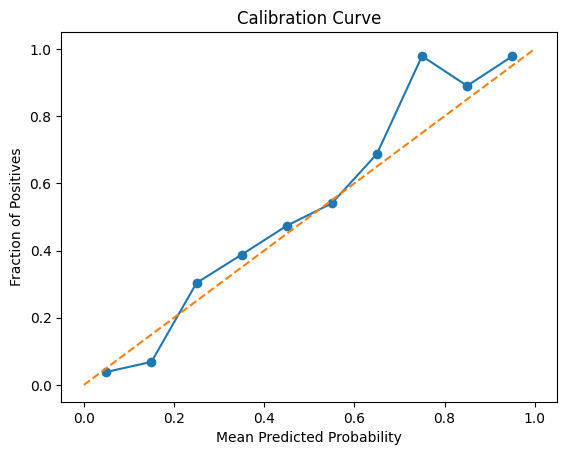

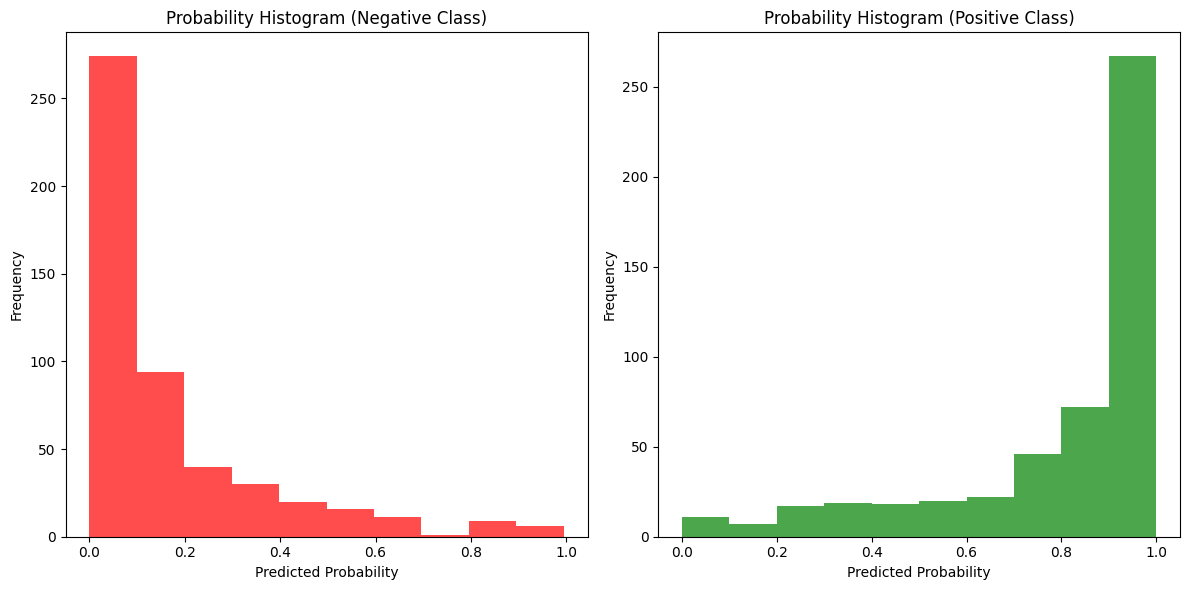

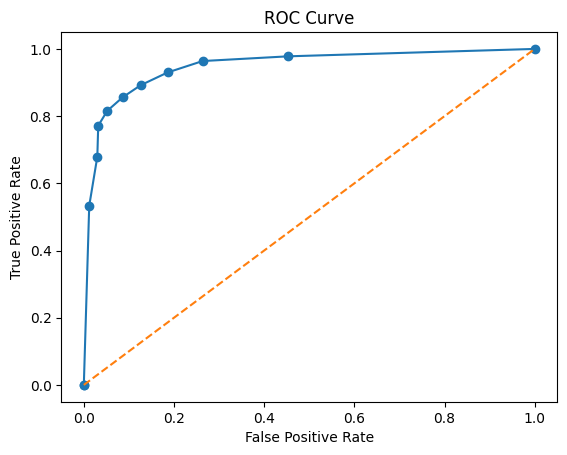

{'Confusion Matrix': [458, 43, 72, 427],
 'Accuracy': 0.885,
 'Precision': 0.9085106382978724,
 'Recall': 0.8557114228456913,
 'Specificity': 0.9141716566866267,
 'F1 Score': 0.8813209494324046}

In [295]:
# TODO: Complete the call for the report with the y_test_prob obtained from the test data
y_test_prob = LogReg_optimum_C_Ridge.predict_proba(X_test)
classification_report(y_test, y_test_prob, 1)

Plot here the differences between the weights for the non-regularized model and the Ridge-regularized one you just obtained. 

[ 1.71922201e-09  3.12539002e-10  3.65650593e-09 -1.24623686e-09
  3.26320732e-09  3.12539002e-10  1.44820891e-09  3.12539002e-10
 -1.24623686e-09  6.83791954e-10 -1.80499016e-09  6.83791954e-10
 -1.24623686e-09  3.65650593e-09 -1.79113532e-09  6.83791954e-10
 -1.79113532e-09 -2.64965699e-10 -1.79113532e-09 -2.64965699e-10]


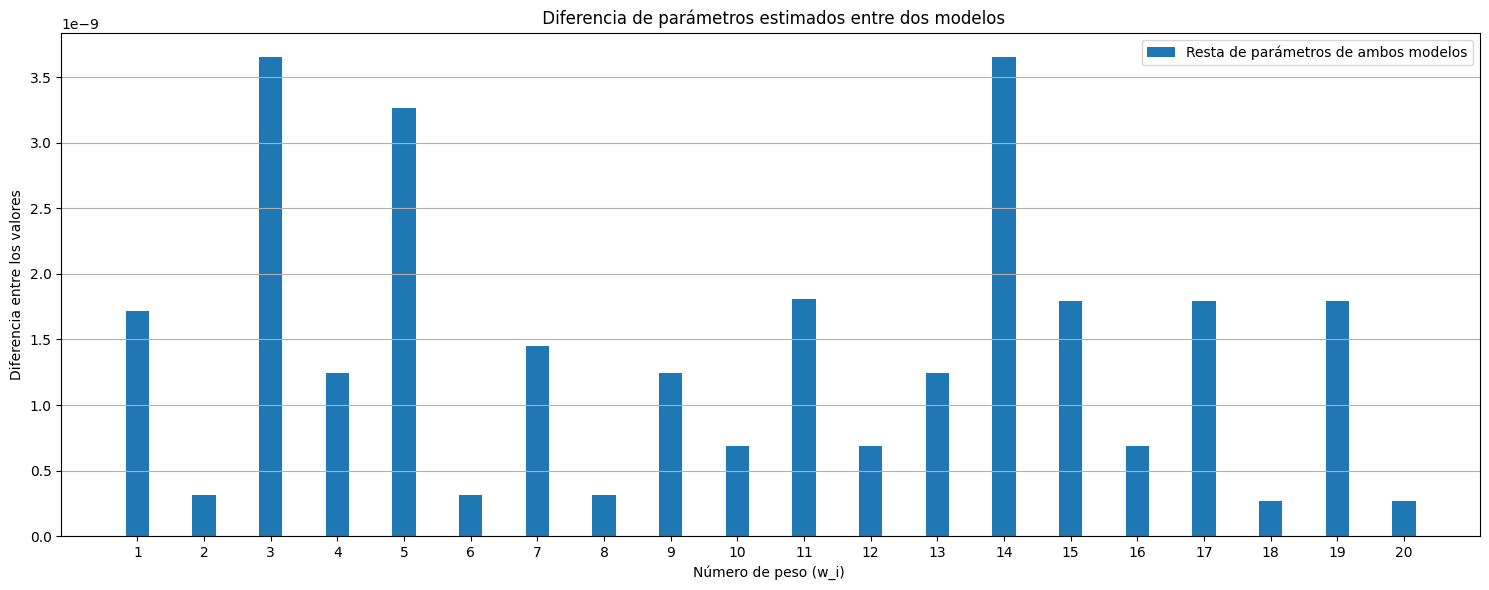

In [296]:
# TODO: Plot an histogram containing the differences between the parameter values for both models


modelo_sin_regularizar = LogisticRegressor() 

modelo_sin_regularizar.fit(X_train,y_train, learning_rate=learning_rate,num_iterations=num_iterations, penalty= None) 

modelo1 = modelo_sin_regularizar.weights 
modelo2 = LogReg_optimum_C_Ridge.weights 
print(modelo1- modelo2)
x = np.arange(1, 21)
width = 0.35


plt.figure(figsize=(15,6))
plt.bar(x, abs(modelo1- modelo2), width=width, label='Resta de parámetros de ambos modelos')


plt.xlabel('Número de peso (w_i) ')
plt.ylabel('Diferencia entre los valores')
plt.title(' Diferencia de parámetros estimados entre dos modelos')
plt.xticks(x)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

**What do you see when you compare this with the original (non-regularized) model?**

>  Vemos que, para cada uno de los estimadores, la diferencia entre los pesos w asignados sin regularizar y los estimados por RIdge con ese valor de C es prácticamente insignificante, siendo 
la mayor diferencia de 4e-9 entre un valor y otro. Esto nos indica que hacer ridge con un valor de C tan bajo es el equivalente a no hacer regularización. Esto tiene sentido, ya que lo que 
en realidad el parámetro C más óptimo es el qeu nos asegura la mayor precisión, manteniendo los valores altos, pero la regularización lo que busca es precisamente reducir el valor de 
esta estimación. Si eso es casi 0, es como no hacerla.

### Lasso

**Lasso regularization is performed introducing what in the objective function?**

> Lasso es una regularización que introduce la criba de las variables que menos afectan al modelo. 

In [297]:
# We will perform regularization for different values of the regularization parameter
# TODO: Create an array (C_values) that contains 11 values distributed in log-scale, covering from 10^(-5) to 10^4
pow_min = -5
pow_max = 4  # In this case we maintain here a 4 instead of a 5 s.a. in the Ridge example

C_values = C_values[:-1] # Vector of \lambda (regularization parameters)
print(C_values)
weights_evolution = []  # To store the final weights for each C
accuracies = []


[1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]


Again, plot and display the following information:
* The evolution for each weight vs. the regularization parameter
* The accuracy of the method vs. the regularization parameter.
    - In this case, mark also the value of the regularization that achieves the highest accuracy
    
**What is the regularization value that achieves highest accuracy?**
> El valor de C que tiene el mayor accuracy es C desde 10-5 hasta 1/10. 

In [298]:

for C in C_values:
    model = LogisticRegressor()  # Update to include necessary parameters
    model.fit(X_train, y_train, learning_rate = learning_rate, num_iterations = num_iterations, penalty = 'lasso', C = C)
    weights_evolution.append(model.weights)
    
    # Predict and calculate accuracy in the test data
    y_pred = model.predict(X_train)
    accuracy = accuracy_score(y_train, y_pred)
    accuracies.append(accuracy)



In [299]:
print(C_values)
print(accuracies)
max_accuracy = max(accuracies)
print(max(C_values))
print(max_accuracy, accuracies.index(max_accuracy))

[1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
[0.88125, 0.88125, 0.88125, 0.88125, 0.88125, 0.881, 0.881, 0.88075, 0.87775, 0.62025]
10000.0
0.88125 0


The optimum value of C based on accuracy is: 1e-05


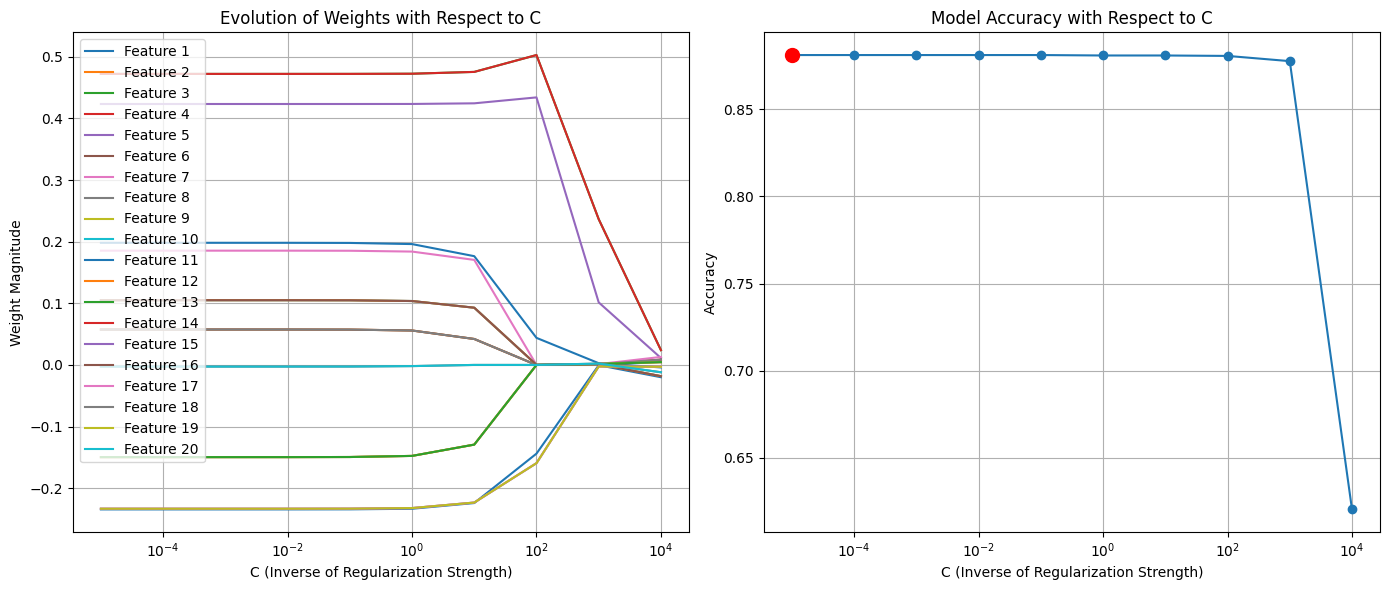

In [300]:

# Plotting the evolution of weights
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for feature_index in range(len(weights_evolution[0])):
    weight_trajectory = [weights[feature_index] for weights in weights_evolution]
    plt.plot(C_values, weight_trajectory, label=f'Feature {feature_index + 1}')
plt.xscale('log')
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('Weight Magnitude')
plt.title('Evolution of Weights with Respect to C')
plt.legend(loc='best')
plt.grid(True)

# TODO: Find the maximum accuracy
max_accuracy = max(accuracies)

# TODO: Filter the C values that correspond to the maximum accuracy
optimum_C_values = C_values[:5]

# Select the maximum C from those that yield the highest accuracy
optimum_C =  min(optimum_C_values)

print(f"The optimum value of C based on accuracy is: {optimum_C}")

# Plotting accuracy as a function of C
plt.subplot(1, 2, 2)
plt.plot(C_values, accuracies, marker='o', linestyle='-')
plt.plot(optimum_C, max_accuracy, 'ro', markersize=10, label='Optimum C')
plt.xscale('log')
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('Accuracy')
plt.title('Model Accuracy with Respect to C')
plt.grid(True)

plt.tight_layout()
plt.show()

**What difference do you observe when you compare with the Ridge regularization case?**
> Vemos que ocurre algo muy parecido . Al hacer regularización , cuando C llega a 1 los valores de cada peso empiezan a bajar. Sim embargo, ahora vemos que 
no lo hacen de la misma manera, al contrario de Ridge, ya que hay valores que llegan a ser 0 antes (como el feature 7) y otros que tardan más (como el 4). 
Esto se debe a que Lasso criba antes los pesos menos significativos. 
Además, podemos ver que a pesar de que se eliminan bastantes variables al llegar a C=100, la accuracy se mantiene, lo que nos enseña que esas variables no eran relevantes a 
la precisión del modelo. Sin embargo, cuando va cribando más variables sí que vemos que a partir de C = 1000 la accucary desciende muchísimo al ser casi todos los parámtros 0 .

Again, create a separate object and train it in the training data with this optimum value of the regularization parameter.

In [301]:
# Initialize the LogisticRegressor model with the optimum C
LogReg_optimum_C_Lasso = LogisticRegressor()

# TODO: Train the model using the training data and the optimum C
LogReg_optimum_C_Lasso.fit(X_train, y_train, 
                           learning_rate = learning_rate, 
                           num_iterations = num_iterations, 
                           penalty = 'lasso', 
                           C = optimum_C)

Apply the `classification_report` function and check out the results

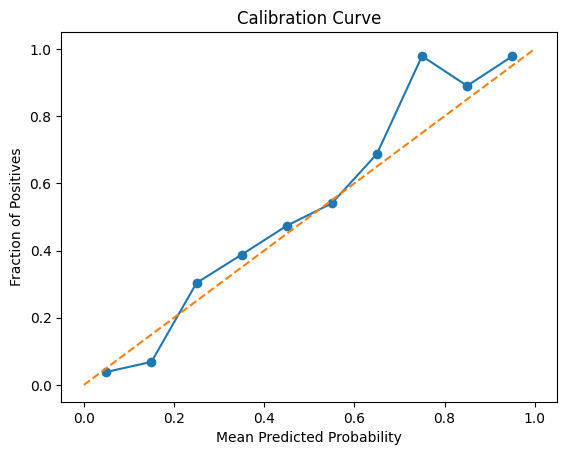

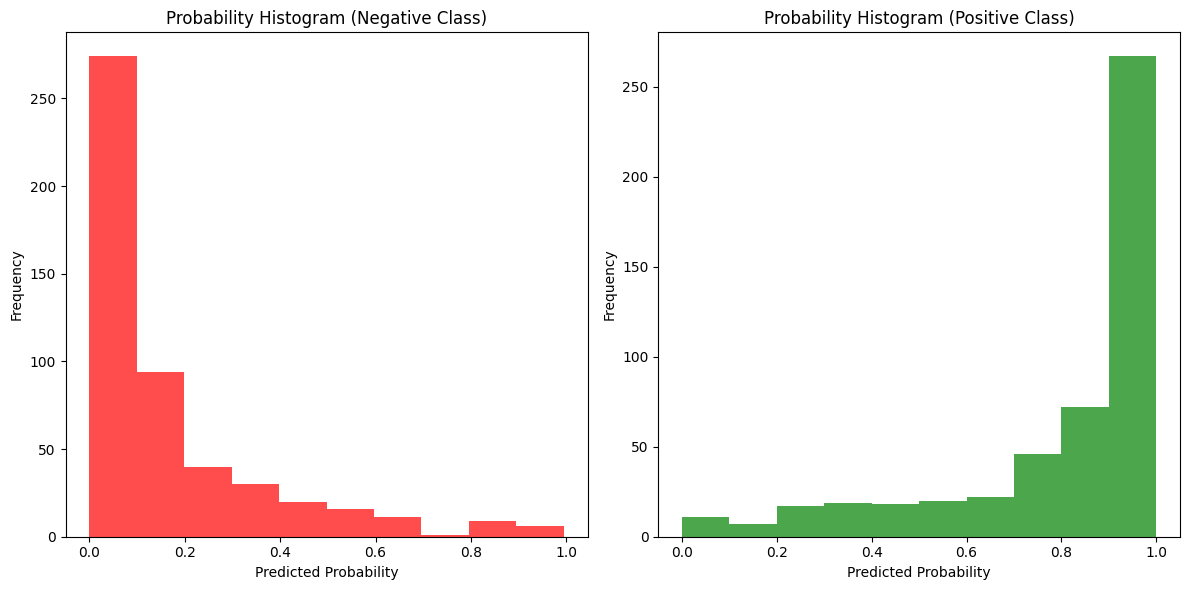

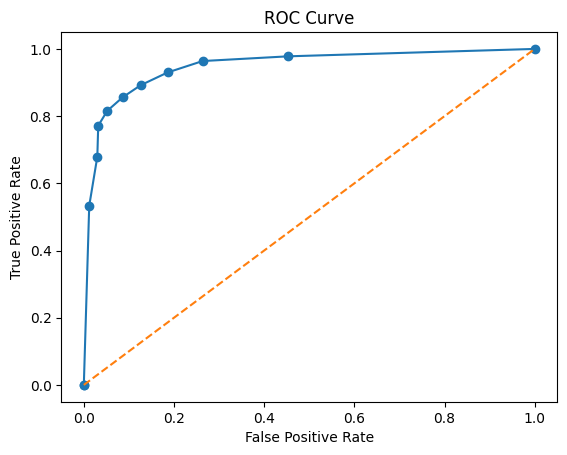

{'Confusion Matrix': [458, 43, 72, 427],
 'Accuracy': 0.885,
 'Precision': 0.9085106382978724,
 'Recall': 0.8557114228456913,
 'Specificity': 0.9141716566866267,
 'F1 Score': 0.8813209494324046}

In [302]:
# TODO: Complete the call for the report with the y_test_prob obtained from the test data
y_test_prob = LogReg_optimum_C_Lasso.predict_proba(X_test)
classification_report(y_test, y_test_prob, 1)

Plot here the differences between the weights for the non-regularized model and this new Lasso-regularized one you just obtained. 

[ 2.13495521e-08  1.57952474e-08 -2.86821245e-09 -2.01513037e-08
 -7.02823133e-10  1.57952474e-08  1.49763853e-08  1.57952474e-08
 -2.01513037e-08  1.27376788e-08 -1.05711537e-08  1.27376788e-08
 -2.01513037e-08 -2.86821245e-09 -1.02937984e-08  1.27376788e-08
 -1.02937984e-08 -6.81028543e-09 -1.02937984e-08 -6.81028543e-09]


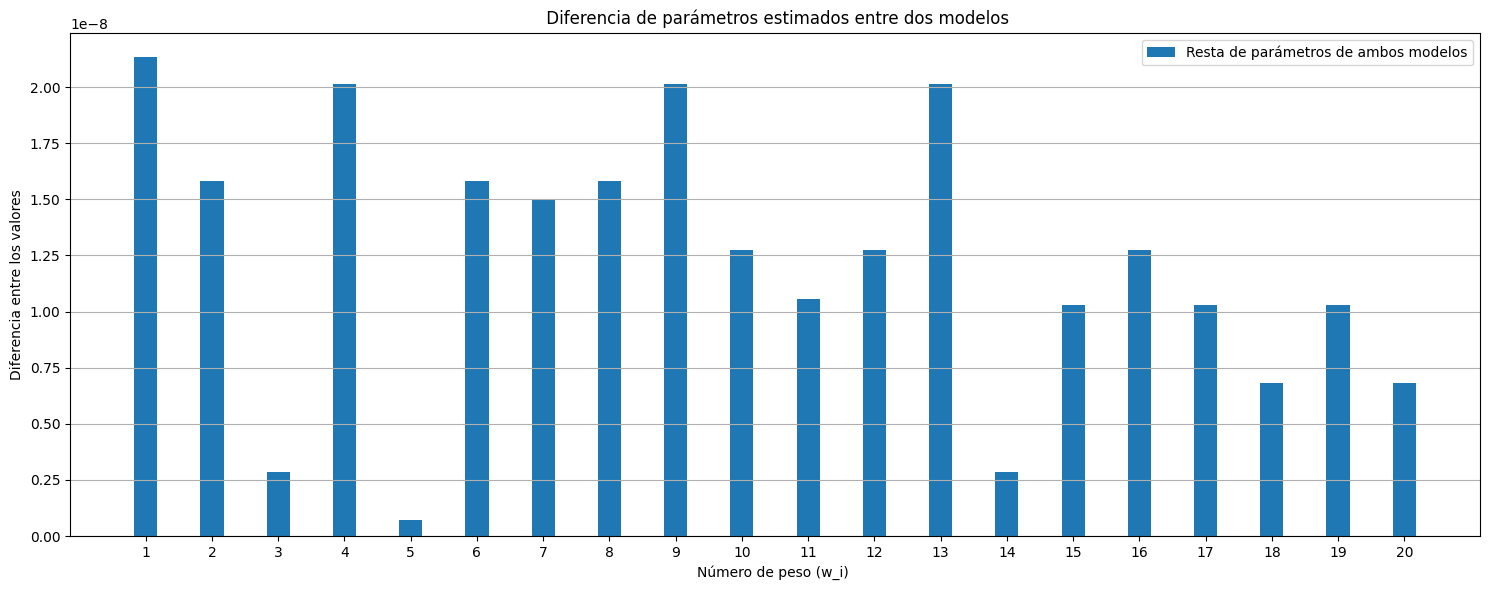

In [303]:
# TODO: Plot an histogram containing the differences between the parameter values for both models


modelo_sin_regularizar = LogisticRegressor() 

modelo_sin_regularizar.fit(X_train,y_train, learning_rate=learning_rate,num_iterations=num_iterations, penalty= None) 

modelo1 = modelo_sin_regularizar.weights 
modelo2 = LogReg_optimum_C_Lasso.weights 
print(modelo1- modelo2)
x = np.arange(1, 21)
width = 0.35


plt.figure(figsize=(15,6))
plt.bar(x, abs(modelo1- modelo2), width=width, label='Resta de parámetros de ambos modelos')


plt.xlabel('Número de peso (w_i) ')
plt.ylabel('Diferencia entre los valores')
plt.title(' Diferencia de parámetros estimados entre dos modelos')
plt.xticks(x)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

**What do you see when you compare this with the original (non-regularized) model?**

> Vemos algo parecido al modelo de Ridge, en el que la diferencia entre los parámetros de entradas y salidas es prácticamente la misma. Ahora, podemos ver que la diferencia es algo mayor, ya que la máxima distancia que podemos encontrar entre un valor de un peso y otro es de 3e-8, mayor que el 4e-9 que encontrábamos antes, enseándonos que el modelo es menos preciso en general que antes. 

### ElasticNet

**ElasticNet regularization is performed introducing what in the objective function?**

> Al hacer la elastic net, tenemos una doble regularización, donde por un lado Lasso va cribando las variables menos importantes, y Ridge reduce sus coeficientes. 

In [304]:
# We will perform regularization for different values of the regularization parameter
# TODO: Create an array (C_values) that contains 11 values distributed in log-scale, covering from 10^(-5) to 10^4
pow_min = -5
pow_max = 4  # In this case we maintain here a 4 instead of a 5 s.a. in the Ridge example

C_values = C_values # Vector of \lambda (regularization parameters)
weights_evolution = []  # To store the final weights for each C
accuracies = []

Again, plot and display the following information:
* The evolution for each weight vs. the regularization parameter
* The accuracy of the method vs. the regularization parameter.
    - In this case, mark also the value of the regularization that achieves the highest accuracy
    
**What is the regularization value that achieves highest accuracy?**
> Por el mismo argumento que en RIdge, elegimos C[0] al ser el menor valor de C que nos permite tener la mejor accuracy

In [305]:
# Assuming the LogisticRegressor class and dataset are prepared
for C in C_values:
    model = LogisticRegressor()  # Update to include necessary parameters
    model.fit(X_train, y_train, learning_rate = learning_rate, num_iterations = num_iterations, penalty = "elasticnet", C = C)
    weights_evolution.append(model.weights)
    
    # Predict and calculate accuracy in the test data
    y_pred = model.predict(X_train)
    accuracy = accuracy_score(y_train, y_pred)
    accuracies.append(accuracy)



In [306]:
print(C_values)
print(accuracies)
max_accuracy = max(accuracies)
print(max(C_values))
print(max_accuracy, accuracies.index(max_accuracy))

[1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
[0.88125, 0.88125, 0.88125, 0.88125, 0.88125, 0.88125, 0.881, 0.881, 0.87975, 0.54625]
10000.0
0.88125 0


The optimum value of C based on accuracy is: 1e-05


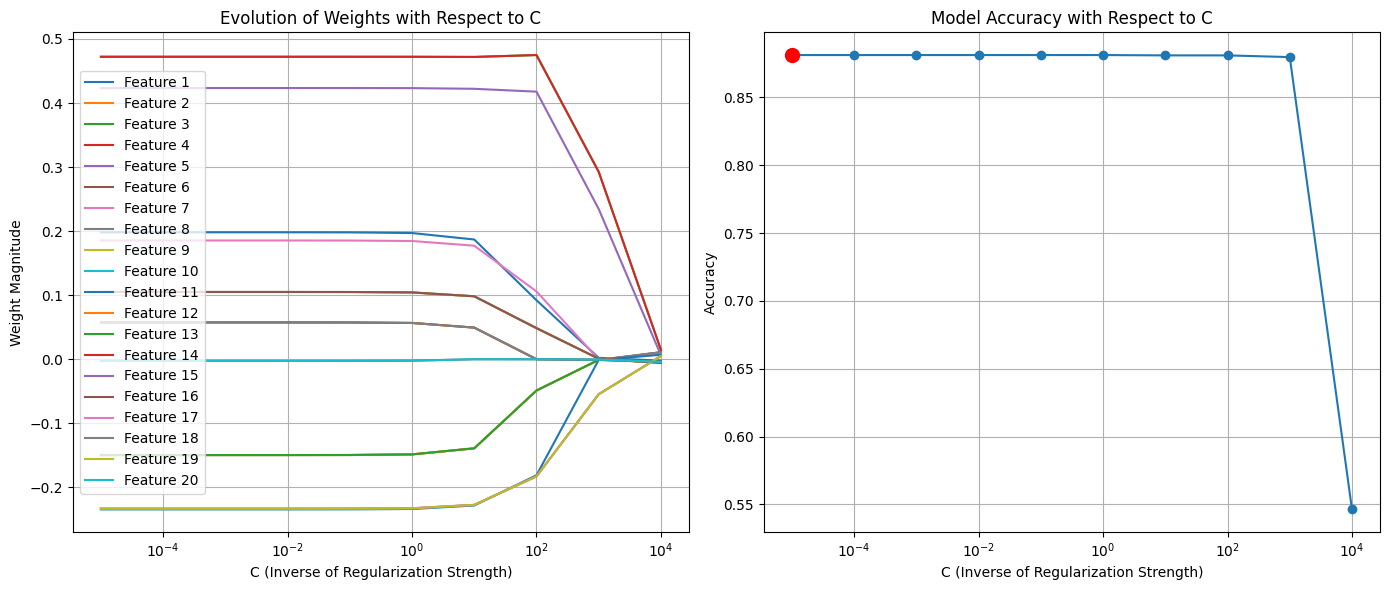

In [307]:


# Plotting the evolution of weights 
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for feature_index in range(len(weights_evolution[0])):
    weight_trajectory = [weights[feature_index] for weights in weights_evolution]
    plt.plot(C_values, weight_trajectory, label=f'Feature {feature_index + 1}')
plt.xscale('log')
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('Weight Magnitude')
plt.title('Evolution of Weights with Respect to C')
plt.legend(loc='best')
plt.grid(True)

# TODO: Find the maximum accuracy
max_accuracy = max(accuracies)

# TODO: Filter the C values that correspond to the maximum accuracy
optimum_C_values = C_values[:5]

# Select the maximum C from those that yield the highest accuracy
optimum_C = min(optimum_C_values)

print(f"The optimum value of C based on accuracy is: {optimum_C}")

# Plotting accuracy as a function of C
plt.subplot(1, 2, 2)
plt.plot(C_values, accuracies, marker='o', linestyle='-')
plt.plot(optimum_C, max_accuracy, 'ro', markersize=10, label='Optimum C')
plt.xscale('log')
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('Accuracy')
plt.title('Model Accuracy with Respect to C')
plt.grid(True)

plt.tight_layout()
plt.show()

**What difference do you observe when you compare with the Ridge regularization case?**
> Vemos un resultado que, dadas las dos aproximaciones de los modelos anteriores, tiene sentido: los coeficientes van a 0 de manera mas "pausada" que antes al limitar Lasso con Ridge, pero se siguen eliminando. 
Por otro lado, vemos que la accuracy cuando C es más de 100 baja drásticamente alcanzando 0.55 , lo cual es muy bajo. Esto tiene sentido porque en ese momento los valores de los pesos son
todos prácticamente nulos, alcanzando un modelo muy underfittted. 

Again, create a separate object and train it in the training data with this optimum value of the regularization parameter.

In [308]:
# Initialize the LogisticRegressor model with the optimum C
LogReg_optimum_C_ElasticNet = LogisticRegressor()

# TODO: Train the model using the training data and the optimum C
LogReg_optimum_C_ElasticNet.fit(X_train, y_train, 
                                learning_rate = learning_rate, 
                                num_iterations = num_iterations, 
                                penalty = 'elasticnet', 
                                C = optimum_C)

Apply the `classification_report` function and check out the results

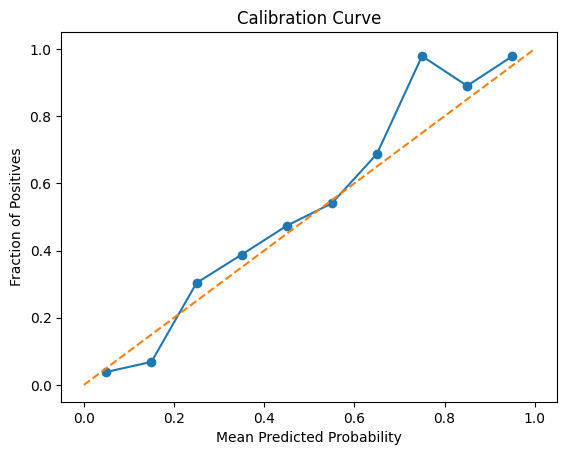

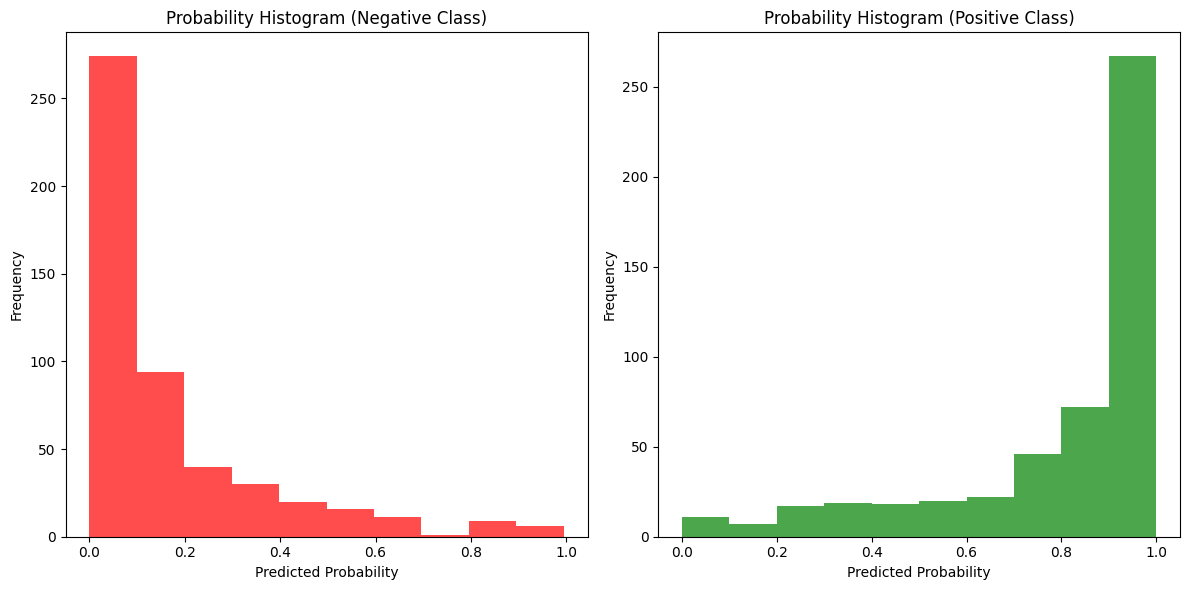

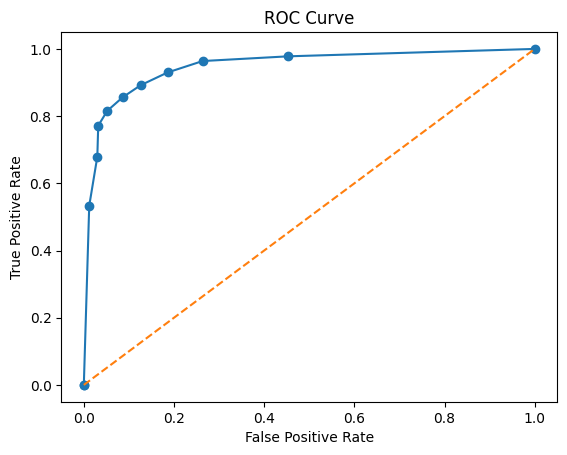

{'Confusion Matrix': [458, 43, 72, 427],
 'Accuracy': 0.885,
 'Precision': 0.9085106382978724,
 'Recall': 0.8557114228456913,
 'Specificity': 0.9141716566866267,
 'F1 Score': 0.8813209494324046}

In [309]:
# TODO: Complete the call for the report with the y_test_prob obtained from the test data
y_test_prob = LogReg_optimum_C_ElasticNet.predict_proba(X_test)
classification_report(y_test, y_test_prob, 1)

Plot here the differences between the weights for the non-regularized model and this new Lasso-regularized one you just obtained. 

[ 1.15343874e-08  8.05389327e-09  3.94146216e-10 -1.06987700e-08
  1.28019223e-09  8.05389327e-09  8.21229751e-09  8.05389327e-09
 -1.06987700e-08  6.71073526e-09 -6.18807217e-09  6.71073526e-09
 -1.06987700e-08  3.94146216e-10 -6.04246708e-09  6.71073526e-09
 -6.04246708e-09 -3.53762556e-09 -6.04246708e-09 -3.53762556e-09]


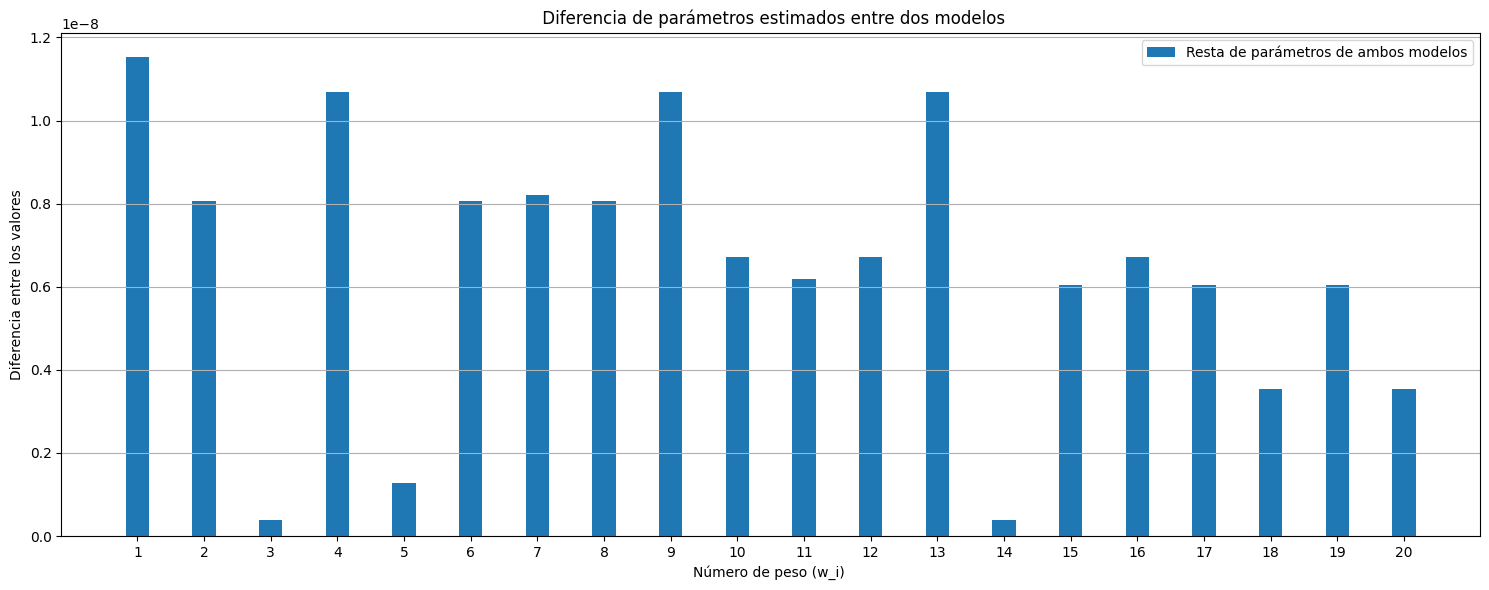

In [310]:
# TODO: Plot an histogram containing the differences between the parameter values for both models


modelo_sin_regularizar = LogisticRegressor() 

modelo_sin_regularizar.fit(X_train,y_train, learning_rate=learning_rate,num_iterations=num_iterations, penalty= None) 

modelo1 = modelo_sin_regularizar.weights 
modelo2 = LogReg_optimum_C_ElasticNet.weights 
print(modelo1- modelo2)
x = np.arange(1, 21)
width = 0.35


plt.figure(figsize=(15,6))
plt.bar(x, abs(modelo1- modelo2), width=width, label='Resta de parámetros de ambos modelos')


plt.xlabel('Número de peso (w_i) ')
plt.ylabel('Diferencia entre los valores')
plt.title(' Diferencia de parámetros estimados entre dos modelos')
plt.xticks(x)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


**What do you see when you compare this with the original (non-regularized) model?**

> Vemos que al haber aplicado Elastic Net, la diferencia de los pesos es casi 4 veces más que en lasso o en ridge, alcanzando valores de orden 1e-3. 

---

**Comparing the un-regularized model with the three other versions with regularization, what do you observe? What can you conclude about the complete analysis?**

> 